# Milestone 1 — Model Training & Evaluation

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, os
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

os.makedirs("../models", exist_ok=True)
print("Imports OK")

Imports OK


In [43]:
# Load preprocessed split data
X_train = pd.read_csv("../data/cleaned/X_train.csv")
X_test  = pd.read_csv("../data/cleaned/X_test.csv")
y_train = pd.read_csv("../data/cleaned/y_train.csv").squeeze()
y_test  = pd.read_csv("../data/cleaned/y_test.csv").squeeze()

print(f"X_train : {X_train.shape}")
print(f"X_test  : {X_test.shape}")
print(f"y_train : {y_train.shape}")
print(f"y_test  : {y_test.shape}")

X_train : (436, 12)
X_test  : (109, 12)
y_train : (436,)
y_test  : (109,)


In [44]:
def evaluate(name, model, X_tr, X_te, y_tr, y_te):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    mae  = mean_absolute_error(y_te, preds)
    rmse = np.sqrt(mean_squared_error(y_te, preds))
    r2   = r2_score(y_te, preds)
    print(f"{name:<25}  MAE={mae:>12,.0f}  RMSE={rmse:>12,.0f}  R²={r2:.4f}")
    return {"Model": name, "MAE": round(mae, 0), "RMSE": round(rmse, 0), "R2": round(r2, 4)}
results = []

In [ ]:
# 1. Linear Regression
lr = LinearRegression()
results.append(evaluate("Linear Regression", lr, X_train, X_test, y_train, y_test))

# 2. Decision Tree
dt = DecisionTreeRegressor(random_state=42)
results.append(evaluate("Decision Tree", dt, X_train, X_test, y_train, y_test))

# 3. Random Forest (baseline)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
results.append(evaluate("Random Forest (base)", rf, X_train, X_test, y_train, y_test))

Linear Regression          MAE=     979,680  RMSE=   1,331,071  R²=0.6495
Decision Tree              MAE=   1,264,367  RMSE=   1,715,038  R²=0.4181
Random Forest (base)       MAE=   1,021,639  RMSE=   1,401,369  R²=0.6115


In [55]:
# 4. Random Forest
param_grid = {
    "n_estimators" : [100, 200],
    "max_depth"    : [None, 10, 20],
    "min_samples_split": [2, 5],
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=1,
    verbose=1
)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV R² :", round(grid_search.best_score_, 4))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best CV R² : 0.6082


In [51]:
# Evaluate tuned model
best_rf = grid_search.best_estimator_
results.append(evaluate("Random Forest (tuned)", best_rf, X_train, X_test, y_train, y_test))

Random Forest (tuned)      MAE=   1,025,545  RMSE=   1,407,359  R²=0.6081


In [53]:
# Model Comparison Summary
summary = pd.DataFrame(results)
summary = summary.sort_values("R2", ascending=False).reset_index(drop=True)
print(" MODEL COMPARISON ")
display(summary)

 MODEL COMPARISON 


,Model,MAE,RMSE,R2
0,Linear Regression,979680.0,1331071.0,0.6495
1,Random Forest (base),1021639.0,1401369.0,0.6115
2,Random Forest (tuned),1025545.0,1407359.0,0.6081
3,Random Forest (tuned),1025545.0,1407359.0,0.6081
4,Decision Tree,1264367.0,1715038.0,0.4181


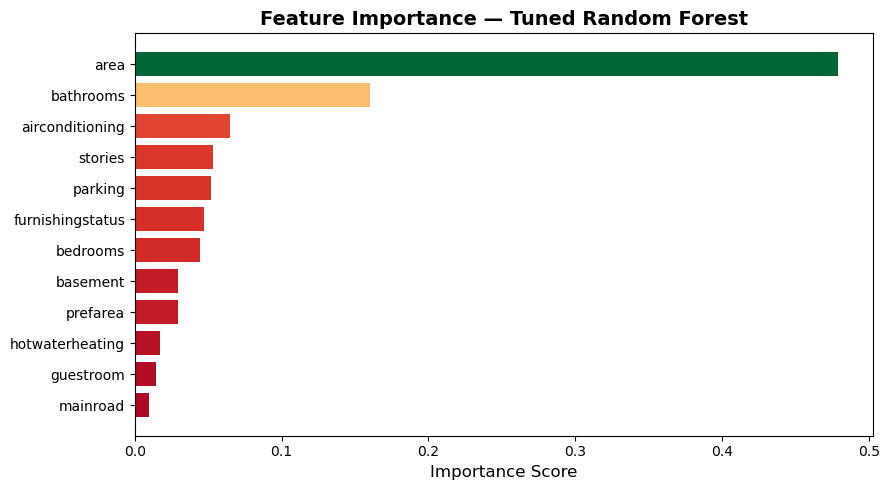

Saved → notebooks/feature_importance.png


In [56]:
# Feature Importance from best Random Forest
importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=True)

plt.figure(figsize=(9, 5))
bars = plt.barh(importances.index, importances.values,
                color=plt.cm.RdYlGn(importances.values / importances.values.max()))
plt.xlabel("Importance Score", fontsize=12)
plt.title("Feature Importance — Tuned Random Forest", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("../notebooks/feature_importance.png", dpi=150)
plt.show()
print("Saved → notebooks/feature_importance.png")

In [57]:
# Save best model
model_path = "../models/best_rf_model.joblib"
joblib.dump(best_rf, model_path)
print(f"Model saved → {model_path}")

Model saved → ../models/best_rf_model.joblib
